Initial setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import wosis
import pandas as pd
import metaknowledge as mk

# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\fuzzywuzzy-0.17.0-py3.6.egg\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
RC = mk.RecordCollection("tmp/filtered_corpora.txt")

In [5]:
# Need config file
wos_config = wosis.load_config('config.yml')

In [6]:
uc_software_packages = wosis.keyword_matches(RC, ['software', 'packages'], threshold=95.0)

In [7]:
all_uc_software = uc_software_packages.combine_recs()

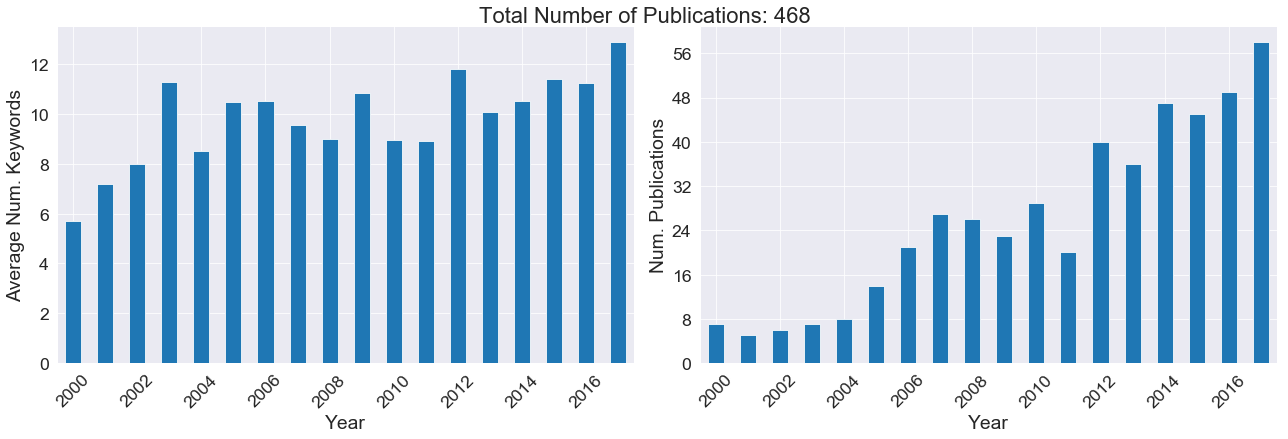

In [8]:
wos_plot.plot_kw_trend(all_uc_software)

In [9]:
software_phrases = wosis.analysis.constrain.find_phrases(wosis.rc_to_df(all_uc_software))

In [10]:
software_phrases.display_phrases()

Parameter estimation and uncertainty analysis for a watershed model (2007) 
https://dx.doi.org/10.1016/j.envsoft.2006.06.007 

This paper explores the use of three such methods, and compares their performance when used in conjunction with a lumped parameter model for surface water flow (HSPF) in a large watershed. 

As well as this, they can provide the modeler with valuable qualitative information on the shape of parameter and predictive probability distributions; these shapes can be quite complex, especially where local objective function optima lie within those parts of parameter space that are considered probable after calibration has been undertaken. 

Where numerical models are employed as an aid to environmental management, the uncertainty associated with predictions made by such models must be assessed. 

Hence similar studies, or extensions of the present study, can be easily undertaken in other modeling contexts by other modelers. 

Nonlinear calibration-constrained optimizat

Groundwater fluxes in a shallow seasonal wetland pond: The effect of bathymetric uncertainty on predicted water and solute balances (2014) 
https://dx.doi.org/10.1016/j.jhydrol.2014.06.020 

We demonstrate that bathymetry can be successfully represented within the model in a simple parametric form using a cubic Sexier curve, allowing an assessment of bathymetric uncertainty due to measurement error and survey detail on the derived groundwater fluxes compared with the fixed bathymetry models. 

Water volume and solute mass balance models can be used in order to derive an estimate of groundwater fluxes within such systems. 

However, such fluxes are hard to quantify. 

We systematically quantify the uncertainty implications for eight different representations of wetland bathymetry for a shallow seasonal wetland pond in South Australia. 

However, the shallow nature of seasonal wetland ponds means water volume and surface area can change rapidly and non-linearly with depth, requiring an a

The software, which is freely available for research purposes, has a graphical user-friendly interface and a flexible design that allows the user to vary the complexity of the model. 

This paper presents IPH-TRIMD-PCLake, a three-dimensional complex dynamic model for subtropical aquatic ecosystems. 


A computer program for a Monte Carlo analysis of sensitivity in equations of environmental modelling obtained from experimental data (2002) 
https://dx.doi.org/10.1016/S0965-9978(02)00023-6 

The authors consider that it is useful to obtain new parameters that relate the sensitivity of the equations to the variations that are produced by the experimental data. 

On the other hand, they discuss a computing algorithm that allows the analysis of sensitivity (and stability) of the mathematical equations, which are built from any methodology. 

On the one hand, the authors present a theoretical study of sensitivity of the models according to different points of view. 

This will allow the sel

For time-dependent PDAEs which can benefit from the use of an adaptive mesh, the resulting method is shown to be highly efficient. 

This paper describes an adaptive algorithm for optimal control of time-dependent partial differential-algebraic equation (PDAE) systems. 


Application of life cycle assessment in the mining industry (2011) 
https://dx.doi.org/10.1007/s11367-010-0246-6 

The paper also shows the variation in functional unit definition for mining LCA studies. 

The paper outlines the benefits of increased application of LCA in the mining industry to LCA databases and all practitioners. 

The paper, however, highlights the major contributions in the literature to LCA practice in the mining industry. 

Research should also be carried out to develop objective ways of characterizing the uncertainty introduced in a LCA study due to the use of secondary data (emissions factors) from prior studies. 

The limited number of mining LCAs may be due to the lack of life cycle thinking 

https://dx.doi.org/10.1007/s12665-011-0908-0 

Mean permeability has the most effect on CO storage capacity and injectivity; k(v)/k(h) affects CO injectivity storage capacity more than permeability variation, V-k. More CO can be stored in the heterogeneous reservoirs with low mean permeability; however, high injectivity can be achieved in the uniform reservoirs with high mean permeability. 

This work studied the effect of completion techniques and reservoir heterogeneity on CO storage and injectivity in saline aquifers using a compositional reservoir simulator, CMG-GEM. 

The heterogeneity effect was addressed by considering three parameters: mean permeability, the vertical to horizontal permeability ratio, and permeability variation. 

Simulation results show that the most favorable option is the perforation of all layers with horizontal wells - m long set in the upper layers. 


A software development framework for structural optimization considering non linear static responses (201

software is employed to evaluate the environmental impacts. 


Two-scale topology design optimization of stiffened or porous plate subject to out-of-plane buckling constraint (2016) 
https://dx.doi.org/10.1007/s00158-016-1542-y 

This paper studies maximum out-of-plane buckling load design of thin bending plates for a given amount of material. 

One is made of periodic homogeneous porous material. 

The new numerical implementation of asymptotic homogenization method (NIAH, Cheng (Acta Mech Sinica (): -, ) and Cai (Int J Solids Struct (), -, ) is applied to homogenization of periodic plate structures and analytic sensitivity analysis of effective stiffness with respect to the topological design variables in both macro-scale and micro-scale. 

The volume preserving nonlinear density filter is applied to obtain the black-white optimum topology and comparison of its different sensitivities is made to show the reason for oscillation during optimization process in Appendix. 

Two kinds of p

The paper describes a software system capable of formulating alternative optimal Municipal Solid Wastes (MSWs) management plans, each of which meets a set of constraints that may reflect selected objections and/or wishes of local communities. 

For each plan formulated, the system generates several reports that define the plan, analyze its cost elements and yield an indicative profile of selected types of installations, as well as data files that facilitate the geographic representation of the optimal solution in maps through the use of GIS. 


Efficient solution for Galerkin-based polynomial chaos expansion systems (2010) 
https://dx.doi.org/10.1016/j.advengsoft.2010.09.004 

The proposed algorithms aim to enable the use of the PCG solver and IC preconditioner in a black-box fashion. 

In this study, approaches for the automated adjustment of the input parameters for these tools are to be introduced. 

As a result, the requirement of the expertise for using these tools is removed to a

Conceptual models include the Saint Venant equation for river flow, the D Darcy equations for confined and unconfined groundwater flow, a two-way hydrological coupling flux in a compartment coupling approach (conductance concept), and Lagrangian particles for solute transport in the river course. 

Groundwater contribution in the moving river water is numerically determined with Lagrangian particles. 


Yield improvement analysis with parameter-screening factorials (2012) 
https://dx.doi.org/10.1016/j.asoc.2011.11.021 

The objective of the work is to improve the manufacturing yield by tuning the parameters that significantly affect the yield. 

After the results were validated by the experts, we designed software that automates the critical parameter analysis process. 

Moreover, by applying the technique to the full list instead of the pre-selected list of the manufacturing parameters, we discovered that the parameters watch list previously identified by the experts should be adjuste

Alternative software platforms for implementing the method are considered, including Bayesian belief networks (BBNs) that facilitate assignment of prior probabilities, specification of relationships among model components, and identification of all output nodes on the probability tree. 

A highly simplified example is presented illustrating assessment of genotoxicity based on studies of DNA damage response caused by naphthalene and its metabolites. 

Uncertainty distributions are derived for maximum likelihood estimate (MLE) and th percentile upper confidence limit (UCL) unit cancer risk estimates, and the effects of resolving selected model uncertainties on these distributions are demonstrated, considering both perfect and partial information for these model components. 

Probabilities are assigned to alternative model components, including the determination of human carcinogenicity, mode of action, the dosimetry measure for exposure, the mathematical form of the dose-response relatio

An important aspect of matrix-based LCA that is straightforward to carry out, but that requires a careful mathematical handling, is the inclusion of sensitivity coefficients based on differentiating the matrix-based formulas. 

Conclusions This paper provides a useful set of tables for a number of purposes related to uncertainty and sensitivity analysis. 

Background, aim, and scope Matrix-based life cycle assessment (LCA) is part of the standard ingredients of modern LCA tools. 

Results We present the complete set of sensitivity coefficients from inventory to weighting through characterization and normalization. 

We show the specific formulas for perturbation analysis, uncertainty analysis, and key issue analysis. 


Effect of bacteria density and accumulated inert solids on the effluent pollutant concentrations predicted by the constructed wetlands model BIO_PORE (2015) 
https://dx.doi.org/10.1016/j.ecoleng.2014.09.069 

Results of the sensitivity analysis showed that the value of 

All three methods proved to be more efficient than manual HSPF calibration. 

Parameter optimization using local and global optimization techniques for the watershed model is discussed. 


Technical and economic survey of low enthalpy solar installations for heating sanitary water (2004) 
https://dx.doi.org/10.1016/j.desal.2004.06.030 

In this context, this investigation focuses on a techno-economic study of a solar power unit for heating sanitary water at low enthalpy. 

These criteria take into account, in particular, the technical models, the recent technological innovations and an accurate analysis of the commercial balance (investment costs, actualised values of energy savings, profitability ratio, etc.). 

The solar energy is the only outside energy whose contribution is permanent to the global scale. 

The study aims, on the one hand, to help the fitters and the industrials in the calculation and the design of such plants, and on the other hand, the economists will be allowed t

The security prediction value is calculated based on the probability distribution of the MC in the steady state. 

To quantitatively predict software security in the design phase, hierarchical software security modeling and evaluation methods are proposed based on Stochastic Petri Nets (SPNs). 

An isomorphic Markov Chain (MC) is obtained from the component SPN model. 


Gulf war contamination assessment for optimal monitoring and remediation cost-benefit analysis, Kuwait (2016) 
https://dx.doi.org/10.1007/s12665-016-6025-3 

x () for the plume volumes and masses (dollars per volume and mass), respectively. 

Site characterization was performed on an area of  km() around the strategically vital freshwater aquifers of the Al-Rawdhatain and Umm Al-Aish to assess the status of groundwater pollution as the result of Iraq invasion to Kuwait in . 

This will reduce the number of samples needed (saves time and money) and provide a superior assessment of the analytes distribution. 

This will 

Most of the approaches perform quite well: computation time on a moderate PC is between a few seconds and a few minutes. 

Results are twofold: they serve as a benchmark to the usefulness and feasibility of these numerical approaches, and they shed light on the question of stability and structure in an often-used large system of interconnected processes. 

Developments in software have enabled the possibility to apply the five example methods to explore the much-used ecoinvent ' database. 

Only Monte Carlo analyses may require much longer, but even then it appears that most questions can be answered within a few hours. 

A previous contribution '(Heijungs & Kleijn ) elaborated five examples of concrete methods within the subset of numerical approaches towards interpretation. 


Hierarchical approach to hydrological model calibration (2017) 
https://dx.doi.org/10.1007/s12665-017-6560-6 

In this study, a hierarchical HRU approach was developed in order to increase model performance and

This paper describes a rigorous sensitivity analysis, automated parameter estimation and evaluation of prediction uncertainty for a Watershed Analysis Risk Management Framework (WARMF) model of the Turkey Creek Watershed. 

Uncertainty associated with all model parameters, including those not estimated by calibration by enhancing the parameter variance/covariance matrix, was considered when evaluating prediction uncertainties. 


Bayesian inference of earthquake parameters from buoy data using a polynomial chaos-based surrogate (2017) 
https://dx.doi.org/10.1007/s10596-017-9646-z 

Finally, the construction of a reduced model dedicated to Bayesian inference is proposed. 

This work addresses the estimation of the parameters of an earthquake model by the consequent tsunami, with an application to the Chile  event. 

Second, the polynomial chaos model is subsequently improved to handle the variability of the arrival time of the wave, using a preconditioned non-intrusive spectral method. 

The generalized likelihood uncertainty estimation (GLUE) was applied to quantify the fluxes' uncertainty, comparing daily-averaged eddy-covariance observations to the output of CSLM. 

Despite the ubiquity of the equifinality issue - different parameter-value combinations yielding equivalent results-the answer to the question was unequivocal: K-d, a measure of how much light penetrates the lake, dominates sensible and latent heat fluxes, and the uncertainty in their estimates is strongly related to the accuracy with which K-d is determined. 


Life cycle energy and costs of sprawling and compact neighborhoods (2017) 
https://dx.doi.org/10.1007/s11367-016-1100-2 

The occupant transportation phase plays a highly important role, since it represents up to  % of total LC CED and up to  % of total LC costs. 

Purpose The aim of this study is to compare the life cycle energy and costs derived from the production and occupation of social interest housing models located in two different types 


TAMkin: A Versatile Package for Vibrational Analysis and Chemical Kinetics (2010) 
https://dx.doi.org/10.1021/ci100099g 

TAMkin is a program for the calculation and analysis of normal modes, thermochemical properties and chemical reaction rates. 


The rocky road to extended simulation frameworks covering uncertainty, inversion, optimization and control (2017) 
https://dx.doi.org/10.1016/j.envsoft.2016.10.003 

While there is an ongoing discussion on quality assurance and reproducibility for simulation frameworks, we have not observed a similar discussion for the extended case. 

Recently, the combination with tools for uncertainty quantification, inverse modelling, optimization and control started a development towards what we call extended simulation frameworks. 

With this, we hope to increase the reliability and transparency of (extended) frameworks, framework use and of the corresponding simulation results. 

Our goal is to start transferring the quality assurance discussion in 

It was also studied numerically on  simulated CSTR experiments on a soil with known equilibrium-kinetic sorption parameters. 

This paper addresses the methodological conditions particularly experimental design and statistical inference ensuring the identifiability of sorption parameters from breakthrough curves measured during stirred flow-through reactor experiments also known as continuous flow stirred-tank reactor (CSTR) experiments. 

EK sorption parameters can not be identified from a single breakthrough curve of a CSTR experiment, because K-d,K- and k(-) were diagnosed collinear. 

For pairs of CSTR experiments, Bayesian inference allowed to select the correct models of sorption and error among sorption alternatives. 


Two-Dimensional Dam-Break Flood Analysis in Data-Scarce Regions: The Case Study of Chipembe Dam, Mozambique (2017) 
https://dx.doi.org/10.3390/w9060432 

Two different DEMs are considered as input for the hydraulic model: a DEM based on the original SRTM data and

We used a Hydrological Simulation Program - Fortran model coupled with the parallel Parameter ESTimation model calibration and uncertainty analysis software to estimate effectively the hydrological interactions between the lakes and the underlying upper Floridan aquifer and the water budgets for these three lakes. 

The average vertical hydraulic conductance (K(v)/b) of the units between a lake bottom and the underlying upper Floridan aquifer in this region are also estimated to be from . 

The annual average vertical leakages estimated for Newnans, Lochloosa, and Orange Lakes are . 

x  m, respectively. 


Verification of computational models of cardiac electro-physiology (2014) 
https://dx.doi.org/10.1002/cnm.2615 

These problems are carefully constructed so that they can be easily run using a general solver and can be used to greatly increase confidence that an implementation is correct, which we illustrate by testing one major solver, 'Chaste', on the problems. 

For computational

As non-structural measure, the Deterministic linear programming (DLP) and chance-constrained linear programming (CCLP) models were developed to allocate available land and water resources optimally on seasonal basis so as to maximize the net annual return from the study area, considering net irrigation water requirement of crops as stochastic variable. 

To develop a long-term sustainable land and water management strategies for the aforementioned issues in humid regions, the district administration realized the need for crop planning and water resources management policies in deterministic and stochastic regimes. 

The sensitivity analysis of conjunctive use of surface water and groundwater shows that % surface water and % groundwater availability as the optimum water allocation level. 

Sensitivity analysis of the models has been carried out by varying three ranges of cropping scenarios (,  and % deviation from the existing cropping pattern) and combinations of surface water and grou

However, the total number of degrees of freedom in the stochastic collocation method can be considerably larger than the number of degrees of freedom in the stochastic Galerkin system. 

The stochastic collocation method requires many solves of deterministic PDEs, which allows the use of existing software. 

The stochastic Galerkin method requires the solution of a single linear system that is several orders larger than linear systems associated with deterministic PDEs. 



Uncertainty in floodplain delineation: expression of flood hazard and risk in a Gulf Coast watershed (2013) 
https://dx.doi.org/10.1002/hyp.9360 

Using the techniques presented here, a standard binary deterministic floodplain delineation is replaced with a flood inundation map showing the underlying flood hazard structure. 

The floodplain with uncertainty for this coastal watershed showed the highest variability in the tidally influenced reaches and showed little variability in the inland riverine reaches. 

This 


Controlling setup cost in (Q, r, L) inventory model with defective items (2010) 
https://dx.doi.org/10.1016/j.apm.2009.04.010 

Finally we develop two computational algorithms to obtain the optimal ordering policy, A computer code using the software Matlab is developed to derive the optimal solution and present numerical examples to illustrate the models. 

This study discusses a mixture inventory model with back orders and lost sales in which the order quantity, reorder point, lead time and setup cost are decision variables. 

Additionally, sensitivity analysis is conducted with respect to the various system parameters. 


Life cycle assessment of the environmental influence of wooden and concrete utility poles based on service lifetime (2017) 
https://dx.doi.org/10.1007/s11367-017-1293-z 

This paper aims to determine the influence of the service lifetime on the potential environmental impacts of wooden and concrete poles in the electricity distribution system. 

Often, the comparis

Sensitivity analyses of population viability analysis (PVA) models can help measure relative parameter influences on predictions, identify research priorities for reducing uncertainty, and evaluate management strategies. 

We provide annotated code so that GRIP may be modified to reflect particular species biology, customized for more complex spatial PVA models, upgraded to incorporate features added in newer versions of RAMAS Metapop, used as a template to develop similar programs, or used as it is for computationally efficient sensitivity analyses in support of conservation planning. 

We developed GRIP, a program to facilitate sensitivity analysis of spatial and nonspatial input parameters for PVAs created in RAMAS Metapop, a widely applied software program. 

Our analysis, however, also underscored the value of exploring the relative influence of spatial parameters on PVA predictions; both SRCs and correlation coefficients indicated that the most influential parameters in the sand 

The detailed investigation of the different membrane elements shows that wastewater reclamation using reverse osmosis technology could be a significant source of low-cost fresh water for hot climate countries. 

The present investigation shows that the tap and brackish water membrane elements are more sensitive to the feed water temperature rather than the feed water pressure and concentration. 


Evaluating the effect of scale in flood inundation modelling in urban environments (2008) 
https://dx.doi.org/10.1002/hyp.7148 

Model results suggests that a coarse resolution model for urban applications is limited by the representation or urban media in coarse model grids. 

Practical application of two-dimensional (D) flood inundation models is often limited by computation time and processing power on standard desktop PCs when attempting to resolve flows on the high-resolution grids necessary to replicate urban features. 

Consequently, it is necessary to evaluate the effectiveness of coa

The outputs (crop yield, water use, and nitrogen uptake) were mapped to show the spatial distribution within each county and aggregated to the county-level over the region of interest. 

The interface was designed to be flexible and easy to apply to applications such as evaluating crop production capacity and response under different scenarios. 

Crop production was simulated for each unique combination of climate, soil, and management for MUs classified as cropland. 


Self-adjoint sensitivity analysis of lossy dielectric structures with electromagnetic time-domain simulators (2008) 
https://dx.doi.org/10.1002/jnm.659 

The computation is performed as an independent post-process outside the solver. 

We present an efficient self-adjoint approach for the computation of response derivatives in lossy inhomogencous structures with time-domain electromagnetic solvers. 

The only requirement is to access the field solution at the perturbation grid points. 

We show that our sensitivity anal

Both the direct method and the adjoint method are employed to derive the sensitivity equations of thermal vibration. 

The coupling effect of heat conduction on thermal vibration in the sensitivity analysis is particularly investigated. 


Integrating environmental gap analysis with spatial conservation prioritization: A case study from Victoria, Australia (2012) 
https://dx.doi.org/10.1016/j.jenvman.2012.07.010 

Our method is based on the conversion of combinations of environmental variables into biodiversity features. 

The question remains of how to fill gaps in conservation systems efficiently. 

When it is applied to identify gaps in the coverage of environmental variables, it embodies the assumption that combinations of environmental variables are effective surrogates for biodiversity attributes. 

We also replicated the analysis by using Species Distribution Models (SDMs) as biodiversity features to evaluate the robustness and utility of our environment-based analysis. 

Gap an

Results shows that the energy saving rate of an optimized rural residence is about -% corresponding to the existing rural residence. 

Energy conservation and energy utilization are important for the green building evaluation criteria (GBEC). 

 

GUI-HDMR - A software tool for global sensitivity analysis of complex models (2009) 
https://dx.doi.org/10.1016/j.envsoft.2008.12.002 

The size of the set of samples is however dependent on the problem and can be successively increased if additional accuracy is required. 

The developed GUI-HDMR software copes very well with the test cases and sensitivity indices of first and second order could be calculated accurately with only low computational effort. 

Extensions to the existing set of random sampling (RS)-HDMR tools have been developed in order to make the method more applicable for complex models with a large number of input parameters as often appear in environmental modelling. 

GUI-HDMR can be applied to a wide range of applications

In particular, examination of monthly streamflow residuals indicated that the normality and independence of model residuals, which are often assumed in parameter estimation and uncertainty analysis, were not always satisfied. 


Fidelity of Network Simulation and Emulation: A Case Study of TCP-Targeted Denial of Service Attacks (2008) 
https://dx.doi.org/10.1145/1456645.1456649 

In this article, we investigate the differences between simulation and emulation when conducting denial of service (DoS) attack experiments. 

We find dramatic differences between simulation and emulation results for DoS experiments. 

As a case study, we consider low-rate TCP-targeted DoS attacks. 

We design constructs and tools for emulation testbeds to achieve a level of control comparable to simulation tools. 


Direct effect of atmospheric turbulence on plume rise in a neutral atmosphere (2017) 
https://dx.doi.org/10.1016/j.apr.2017.01.001 

The direct effect of atmospheric turbulence on plume rise in th

The related work includes performance of the following tasks: to study gas pipeline combustion model, to identify uncertainty of model inputs noting their variation range, and to apply uncertainty and sensitivity analysis for results of this model. 

The rupture of a high-pressure natural gas pipeline can lead to consequences that can pose a significant threat to people and property in the close vicinity to the pipeline fault location. 

For this purpose, authors present available statistical information and probabilistic analysis related to failures of natural gas pipelines. 

The measures of uncertainty and sensitivity analysis were estimated and outcomes presented applying software system for uncertainty and sensitivity analysis. 


Computer simulation model for determining reclamation liability costs of the Ekati Diamond Mine (TM) in the Northwest Territories, Canada (2006) 
https://dx.doi.org/10.1016/j.jclepro.2004.10.006 

These methods are limited in their ability to account for

Distance-based and stochastic uncertainty analysis for multi-criteria decision analysis in Excel using Visual Basic for Applications (2006) 
https://dx.doi.org/10.1016/j.envsoft.2005.08.004 

A program has been developed in Excel and written in Visual Basic for Applications, which enables a decision maker to examine the robustness of a solution obtained when using multi-criteria decision analysis (MCDA). 

The Weighted Sum Method (WSM) and PROMETHEE are the MCDA techniques available for the user to select in the program. 

The uncertainty analysis methodology overcomes the limitations of existing sensitivity analysis techniques for MCDA by enabling all of the input parameters to be varied simultaneously within their expected ranges. 


Stability analysis of rotary power flow controller (2015) 
https://dx.doi.org/10.1002/jnm.2025 

In this paper, a linear model is developed for RPFC in the dq-reference frame. 

This device comprises a shunt and a series transformer and two RPSTs. 

Effe

Based on these findings, several improvements could be put forward, for instance, optimized design for motor efficiency of the Quayside Crane was recognized as the most effective way to reduce the environmental impacts which should be urgently amended. 

Accordingly recovery of materials, such as steel reuse after refurbishment in the end-of-life stage could notably diminish most of the environmental impacts. 

Its purpose was to identify the key processes that effected the environment, as well as, sought out opportunities for improving the environmental profiles of Quayside Cranes. 

The results showed that nearly all environmental impact categories and life cycle costs were relatively high in the utilization stage. 


Robust satellite techniques for seismically active areas monitoring: a sensitivity analysis on September 7, 1999 Athens's earthquake (2004) 
https://dx.doi.org/10.1016/j.pce.2003.11.019 

In this paper the actual potential of satellite TIR surveys is evaluated on the ba

https://dx.doi.org/10.1007/s00158-009-0451-8 

Our approach is illustrated by a real-world example from papermaking industry. 


Estimating storm discharge and water quality data uncertainty: A software tool for monitoring and modeling applications (2009) 
https://dx.doi.org/10.1016/j.envsoft.2008.12.006 

For storm loads, the uncertainty was typically least for discharge (+/- -%), greater for sediment (+/- -%) and dissolved N and P (+/- -%) loads, and greater yet for total N and P (+/- -%). 

Hydrologic and water quality data are too important for scientists to continue to ignore the inherent uncertainty. 

With these benefits in mind, the Data Uncertainty Estimation Tool for Hydrology and Water Quality (DUET-H/WQ) was developed from an existing uncertainty estimation framework for small watershed discharge, sediment, and N and P data. 

When these uncertainty estimates for individual values were aggregated within study periods (i.e. 

DUET-H/WQ lists published uncertainty information

In this article, empirical methods and numerical modelling using UDEC software were used to conduct a stability analysis of the access tunnel at the Shahriar dam crest, which was one of the most important tunnels of this project. 

Empirical methods are based on the experience gathered by researchers in various parts of the world whereas numerical modelling utilises computing power and, using various modelling techniques, can be a precise way of solving very complex problems. 

This method allows the user to conduct sensitivity analysis. 


Model development and process simulation of postcombustion carbon capture technology with aqueous AMP/PZ solvent (2016) 
https://dx.doi.org/10.1016/j.ijggc.2016.01.021 

g/t CO to . 

The uncertainty analysis shows that the model is well capable of predicting experimental and pilot result. 

GJ/t CO. Only amine slip to the atmosphere increases with AMP/PZ technology: from . 

This study presents the development, application, and uncertainty analysis

Engagement with the policy process. 

This paper aims to provide insight into the design and development process of policy support systems that incorporate integrated models. 

The development of Decision Support Systems (DSS) to inform policy making has been increasing rapidly. 

It will provide a methodology for the development of such systems that attempts to synthesize knowledge and experience gained over the past - years from developing a suite of these DSSs for a number of users in different geographical contexts worldwide. 

The methodology focuses on the overall iterative development process that includes policy makers, scientists and IT-specialists. 


Discrete element representation of manure products (2006) 
https://dx.doi.org/10.1016/j.compag.2005.10.004 

A procedure was also developed to create clusters of particles randomly oriented and located within the modeled domain. 

A sensitivity analysis was performed to study the influence of parameters defining the linear and H

HBV-Ensemble was administered in a class for both in-class instruction and a final project, and students submitted their feedback about the toolbox. 


Chaospy: An open source tool for designing methods of uncertainty quantification (2015) 
https://dx.doi.org/10.1016/j.jocs.2015.08.008 

(C)  The Authors. 

The paper compares Chaospy to similar packages and demonstrates a stronger focus on defining reusable software building blocks that can easily be assembled to construct new, tailored algorithms for uncertainty quantification. 


Series of experiments for empirical validation of solar gain modeling in building energy simulation codes - Experimental setup, test cell characterization, specifications and uncertainty analysis (2006) 
https://dx.doi.org/10.1016/j.buildenv.2005.07.020 

A good foundation for the following experiments with solar gains was therefore accomplished. 

A transient experiment, also without solar gains, and corresponding simulations from four different building en

This contribution provides CFs to allow for the quantification of noise impacts on human health in the LCA framework. 

A Monte Carlo-based quantitative global sensitivity analysis method was applied to evaluate the importance of the input factors in determining the variance of the output. 

urban day with a frequency of  Hz, rural night at  Hz, etc.). 

Noise propagation standards and international reports on acoustics and noise impacts were used to define the model parameters. 

A total of  spatial and  archetypal CFs were produced to evaluate noise impacts at a European level (i.e. 


Methods and object-oriented software for FE reliability and sensitivity analysis with application to a bridge structure (2007) 
https://dx.doi.org/10.1061/(ASCE)0887-3801(2007)21:3(151) 

The product is a comprehensive and freely available library of software tools for finite-element reliability and response sensitivity analysis. 

The required response sensitivities are obtained by an extensive implem

Minmax regret combinatorial optimization problems with investments (2017) 
https://dx.doi.org/10.1016/j.cor.2017.03.007 

In this model it is allowed to make investments before a minmax regret solution is implemented in order to modify the source or the nature of the existing uncertainty. 

A new minmax regret optimization model in a system with uncertain parameters is proposed. 

As a practical application we consider the shortest path problem in a network in which it is possible to modify the uncertainty intervals for the arc costs by investing in the system. 


Generating probabilistic spatially-explicit individual and population exposure estimates for ecological risk assessments (2000) 
https://dx.doi.org/10.1111/0272-4332.205053 

Results indicate that () any single estimator may over- or underestimate exposure, depending on foraging strategy and spatial relationships of habitat and contamination, and () changes in exposure estimates in response to changes in foraging and habitat 

The result of the sensitivity analysis carried out on the electricity mix used during the GnP and the composite production processes does not affect the conclusions. 


Parallel computing techniques for sensitivity analysis in optimum structural design (2007) 
https://dx.doi.org/10.1016/(ASCE)0887-3801(2007)21:6(463) 

single-level and multilevel parallelisms are pursued for design sensitivities. 

The parallel algorithms for design sensitivity analysis have been implemented on message passing parallel systems within the software platform of Parallel Computer Adaptive Language. 

Numerical studies show that the performance of the parallel algorithms for design sensitivities on message passing systems is very good. 


Life cycle assessment of Australian automotive door skins (2009) 
https://dx.doi.org/10.1007/s11367-009-0103-7 

Global Warming Potential (GWP) also follows a trend similar to that of energy consumption. 

In general, the air emissions during the use phase are strongly dep

A sensitivity analysis of the rheological and entrainment parameters was carried out and the effects of modeling with entrainment on the debris flow run-out, height and velocity were assessed. 

The entrainment process is evidently an important factor that can further determine the magnitude and intensity of debris flows. 


Life cycle analysis of pistachio production in Greece (2017) 
https://dx.doi.org/10.1016/j.scitotenv.2017.03.251 

Regarding energy consumption, the WU scenario results in minor increase, %, compared to the BS scenario. 

Based on the results of this study, the use of compost for fertilization (GE scenario), which results in approximately % savings in terms of energy consumption and the five environmental impact categories studied compared to BS scenario, is considered a promising alternative cultivation strategy. 

In the present paper, a life cycle assessment (LCA) study regarding pistachio (Pistacia vera L.) cultivation in Aegina island, Greece, was performed to

The initial goal was to identify the most effective ways to present EOS uncertainty to analysts, code developers, and material modelers. 

Material model stakeholders contribute and extract information at different points in this workflow depending on their role, but encounter various institutional and technical barriers which restrict the flow of information. 


Simulating the Fate and Transport of Coal Seam Gas Chemicals in Variably-Saturated Soils Using HYDRUS (2017) 
https://dx.doi.org/10.3390/w9060385 

The HYDRUS-D and HYDRUS (D/D) computer software packages are widely used finite element models for simulating the one-, and two- or three-dimensional movement of water, heat, and multiple solutes in variably-saturated media, respectively. 

The objective of this paper is to provide a brief overview of the HYDRUS models and their add-on modules, and to demonstrate possible applications of the software to the subsurface fate and transport of chemicals involved in coal seam gas extrac

In addition to the software framework, we also provide guidelines as to the applicability and efficiency of Bayesian tools when applied to computationally demanding physical models. 


Spatio-temporal uncertainty in Spatial Decision Support Systems: A case study of changing land availability for bioenergy crops in Mozambique (2012) 
https://dx.doi.org/10.1016/j.compenvurbsys.2011.08.003 

It uses the PCRaster Python framework, which comprises both a spatio-temporal modeling framework and a Monte Carlo analysis framework that together produce stochastic maps, which can be visualized with the Aguila software, included in the PCRaster Python distribution package. 

Spatial Decision Support Systems (SDSSs) often include models that can be used to assess the impact of possible decisions. 

These models usually simulate complex spatio-temporal phenomena, with input variables and parameters that are often hard to measure. 

It is shown how the uncertainty of the input variables and model para

and expressed with the Eco-indicator  life cycle impact assessment method. 

According to the survey data, discarded TV sets accounted for the highest proportion of e-waste treated in the enterprise in . 

For a sensitivity analysis of the overall LCA results, the so-called CML method is used in order to estimate the influence of the choice of the assessment method on the result. 

Electrical and electronic waste (e-waste) has become one of the fastest growing waste streams in the world, and many countries have established e-waste treatment enterprises to solve their e-waste problems. 

The e-waste treatment had little environmental impact, and at the same time large environmental benefits can be achieved mainly due to the recycled resources and reuse of some components. 


Automatic sensitivity analysis of a finite volume model for two-dimensional shallow water flows (2007) 
https://dx.doi.org/10.1007/s10652-007-9028-5 

Numerical tests were done to show the robustness of the model an

Results have been presented for the environmental impact categories deemed most relevant to vehicle use. 

The  kg weight saving accounts for the majority of the difference in impacts between the two B-pillar designs. 

Impacts from manufacturing were also lower for the new design for all of the impact categories assessed despite the higher alloy content of the steel. 

The assessment indicates that significant improvements in the environmental impacts associated with the body structure of vehicles could be made through the increased use of AHSS in vehicles without compromising crash performance. 


Borehole Optimisation System (BOS) - A case study assessing options for abstraction of urban groundwater in Nottingham, UK (2008) 
https://dx.doi.org/10.1016/j.envsoft.2007.09.001 

These areas have the highest potential PCE concentrations. 

The risk of pollution in potential new boreholes from the industrial chlorinated solvent tetrachloroethene (PCE) was assessed for this region. 

These

The outcome of the analysis was detailed maps (as GIS layers) illustrating the location of depressions with depths, surface area and volume data for each depression. 

Furthermore, preferential flow paths, catchment boundaries and ranking of each depression were calculated. 

Finally, a method for assessing flood risk at a more advanced level (hydrodynamic simulation of surface and drainage) was developed and used on a specific blue spot as an example. 


A long-term sensitivity analysis of the denitrification and decomposition model (2013) 
https://dx.doi.org/10.1016/j.envsoft.2013.01.005 

We used a method of Bayesian analysis of computer code outputs (BACCO) with the Gaussian emulation machine for sensitivity analysis software (GEM-SA) to conduct a long-term SA of DNDC for predicting the annual change of soil organic carbon (dSOC), nitrous oxide emission (NO) and grain yield of spring wheat. 

Twenty seven non-weather input parameters with wide ranges were selected for SA using weat

<hr>
Create a dataframe of relevant papers

<hr>
Software packages trend

<hr>
Network analysis